## Import necessary packages

In [1]:
import numpy as np
import scipy.io
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import nibabel as nib
import os

import datetime
import time
import sys
import warnings
import glob

import seaborn as sns
from sklearn.metrics import pairwise_distances

code_folder = os.getcwd()
path_to_functions = os.path.join(code_folder, '..')
sys.path.insert(0, path_to_functions)
import functions as funcs
import importlib
importlib.reload(funcs)

from matplotlib.ticker import PercentFormatter
# import netplotbrain
from nilearn import plotting
import matplotlib.cm as cm
import matplotlib.colors as colors
import nilearn
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Global variables

In [2]:
num_parcels = 116
num_cortical_parcels = 100

tau_min = 0
tau_max = 3

pc_alpha = 1
alpha_level = 1e-2/32     # 32 comes from correction for multiple comparisons accross lags (number of lags including lag 0 = 4)

num_subjects_ready = 200
num_networks = 16

network_dic = "{'Vis':[],'Som':[],'Dor':[],'Sal':[], 'Lim':[], 'Con':[], 'Def':[], 'Sub' :[]}"
net_labels = ['Vis','Som','Dor','Sal', 'Lim', 'Con', 'Def', 'Sub']

net_labels_visualization = ['Vis','Som-Mot','Dors-Att','Vent-Att', 'Lim','Cont','Def','Sub']


## Set the Path to External Packages and Files, Results, and Data

In [3]:
code_folder = os.getcwd()
files_folder = os.path.join(code_folder, '..', 'External Packages and Files')
results_folder = os.path.join(code_folder, '..', 'Results')
data_folder = os.path.join(code_folder, '..', 'Data')

# Read cortical and subcortical parcel labels

In [4]:
#Read cortical and subcortical parcel labels
df_cortical = pd.read_csv(os.path.join(files_folder, 'Schaefer2018_100Parcels_7Networks_order.txt'), delimiter = '\t', header=None)
df_subcortical = pd.read_csv(os.path.join(files_folder, 'Tian_Subcortex_S1_3T_label.txt'), delimiter = '\t', header=None)

Schaefer2018_100Parcels_7Networks_labels = df_cortical[1]
Tian_Subcortex_S1_3T_labels = list(df_subcortical[0])

parcel_labels = []
parcel_labels_short = []

for i in range(0,num_parcels):
    if i < num_cortical_parcels:
        parcel_labels.append(Schaefer2018_100Parcels_7Networks_labels[i][10:])

    else:
        parcel_labels.append(Tian_Subcortex_S1_3T_labels[i-num_cortical_parcels])

    parcel_labels_short.append(parcel_labels[i][0:6])
parcel_labels

['LH_Vis_1',
 'LH_Vis_2',
 'LH_Vis_3',
 'LH_Vis_4',
 'LH_Vis_5',
 'LH_Vis_6',
 'LH_Vis_7',
 'LH_Vis_8',
 'LH_Vis_9',
 'LH_SomMot_1',
 'LH_SomMot_2',
 'LH_SomMot_3',
 'LH_SomMot_4',
 'LH_SomMot_5',
 'LH_SomMot_6',
 'LH_DorsAttn_Post_1',
 'LH_DorsAttn_Post_2',
 'LH_DorsAttn_Post_3',
 'LH_DorsAttn_Post_4',
 'LH_DorsAttn_Post_5',
 'LH_DorsAttn_Post_6',
 'LH_DorsAttn_PrCv_1',
 'LH_DorsAttn_FEF_1',
 'LH_SalVentAttn_ParOper_1',
 'LH_SalVentAttn_FrOperIns_1',
 'LH_SalVentAttn_FrOperIns_2',
 'LH_SalVentAttn_PFCl_1',
 'LH_SalVentAttn_Med_1',
 'LH_SalVentAttn_Med_2',
 'LH_SalVentAttn_Med_3',
 'LH_Limbic_OFC_1',
 'LH_Limbic_TempPole_1',
 'LH_Limbic_TempPole_2',
 'LH_Cont_Par_1',
 'LH_Cont_PFCl_1',
 'LH_Cont_pCun_1',
 'LH_Cont_Cing_1',
 'LH_Default_Temp_1',
 'LH_Default_Temp_2',
 'LH_Default_Par_1',
 'LH_Default_Par_2',
 'LH_Default_PFC_1',
 'LH_Default_PFC_2',
 'LH_Default_PFC_3',
 'LH_Default_PFC_4',
 'LH_Default_PFC_5',
 'LH_Default_PFC_6',
 'LH_Default_PFC_7',
 'LH_Default_pCunPCC_1',
 'LH_Defa

# Standard Colors for Yeo2011, 7 Networks

In [5]:
dataframe = pd.read_csv(os.path.join(files_folder, 'Yeo2011_7Networks_ColorLUT.txt'), delimiter='\t')
Yeo2011_7Networks_ColorLUT = np.array([[120,  18, 134], [70, 130, 180],[0, 118,  14],[196,  58, 250], [220, 248, 164],[230, 148,  34], [205,  62,  78]])

In [6]:
Yeo2011_7Networks_ColorLUT

array([[120,  18, 134],
       [ 70, 130, 180],
       [  0, 118,  14],
       [196,  58, 250],
       [220, 248, 164],
       [230, 148,  34],
       [205,  62,  78]])

# Parcel Indices in Each Subnetwork

In [7]:
num_networks = len(net_labels)
network_parcel_idx= eval(network_dic)

for i in range (0 , num_parcels):
    temp = parcel_labels[i]
    temp_first = temp[3:6]
    if temp_first in network_parcel_idx:
        network_parcel_idx[temp_first].append(i)

    if i>=100:
        network_parcel_idx['Sub'].append(i)            

# Cortical and subcortical parcel coordinates

In [8]:
# cortical
cortical_parcel_locs_dataframe = pd.read_csv(os.path.join(files_folder, 'Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'))

cortical_parcel_locs_R = np.reshape(np.array(cortical_parcel_locs_dataframe['R']), (num_cortical_parcels,1))
cortical_parcel_locs_A = np.reshape(np.array(cortical_parcel_locs_dataframe['A']),(num_cortical_parcels,1))
cortical_parcel_locs_S = np.reshape(np.array(cortical_parcel_locs_dataframe['S']), (num_cortical_parcels,1))
cortical_parcel_locs = np.concatenate((cortical_parcel_locs_R, cortical_parcel_locs_A, cortical_parcel_locs_S), axis = 1)

# subcortical
subcortical_parcel_locs_dataframe = pd.read_csv(os.path.join(files_folder,'Tian_Subcortex_S1_3T_COG.txt'), delimiter = '\t', header =  None)
subcortical_parcel_locs = np.array(subcortical_parcel_locs_dataframe)

parcel_locs = np.concatenate((cortical_parcel_locs, subcortical_parcel_locs), axis = 0)

# HCP resting-state fMRI data

### Select subjects

In [9]:
subjs = scipy.io.loadmat(os.path.join(data_folder,'HCP/subjs.mat'))['subjs']

num_subjects = len(subjs)
selected_subjects_name = []

for s in range(0, num_subjects):
    
    temp_subj = scipy.io.loadmat(os.path.join(data_folder,'HCP/subjs.mat'))['subjs'][s][0]
    selected_subjects_name.append(temp_subj) 

print('Total number of subjects:', num_subjects)

Total number of subjects: 700


# Causality Analysis

##  CaLLTiF Results on HCP Resting-State fMRI

### Load results

In [10]:
def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle= True)
    for varName in Data:
        globals()[varName] = Data[varName]  

In [11]:
import_npz(os.path.join(results_folder,'multipledataset_calltif_hcp_rest.npz'))


In [12]:
time_series_graph_hcp_rest_all_subjects = []
time_series_graph_hcp_rest_all_subjects_pvalues = []

hcp_rest_all_graphs = []
hcp_rest_all_graphs_p_values = []

for s in range(0, num_subjects_ready):

    final_graph_org = multipledataset_calltif_hcp_rest_link_matrix[s]['graph']
    p_matrix = np.array(multipledataset_calltif_hcp_rest_link_matrix[s]['p_matrix'])
    
    # Threshold p_matrix to get graph
    final_graph_new = p_matrix <= alpha_level
    
    # Convert to string graph representation
    graph = funcs.convert_to_string_graph(final_graph_new)

    # Time series graph
    time_series_graph_hcp_rest_all_subjects.append(graph)
    time_series_graph_hcp_rest_all_subjects_pvalues.append(p_matrix)

    # combined graph across lags
    summary_graph, binary_matrix , binary_matrix_p_value= funcs.summarize_across_all_lags_v2_with_pvalues(graph, p_matrix)
    
    hcp_rest_all_graphs.append(binary_matrix)
    hcp_rest_all_graphs_p_values.append(binary_matrix_p_value)

### Parcel-Level Graph Parameters

In [13]:
num_cortical_networks = 7
all_networks_num_edges_from_to_individual_sub = np.zeros((num_cortical_networks, num_cortical_networks, num_subjects_ready))

for s in range(num_subjects_ready):

    graph = hcp_rest_all_graphs[s]

    # look at the networks
    all_networks_num_edges_from_to = funcs.network_map_v2(graph,net_labels, network_dic, parcel_labels, num_cortical_parcels)
    all_networks_num_edges_from_to_individual_sub[:,:,s] = all_networks_num_edges_from_to[:-1, :-1]

### Subnetwork Graphs

#### Average subnetwork graph (averaged over subnetwork graphs of 200 subjects)

In [14]:
average_subnetwork_graph_over_all_subjects = np.mean(all_networks_num_edges_from_to_individual_sub, axis = 2)

average_subnetwork_graph_over_all_subjects_visualization = np.floor(average_subnetwork_graph_over_all_subjects*100)/100
average_subnetwork_graph_over_all_subjects_visualization[average_subnetwork_graph_over_all_subjects_visualization<0.50] = 0

average_subnetwork_causal_flow = np.mean(average_subnetwork_graph_over_all_subjects_visualization, axis = 1)- np.mean(average_subnetwork_graph_over_all_subjects_visualization, axis = 0)
average_subnetwork_nodal_degree= np.mean(average_subnetwork_graph_over_all_subjects_visualization, axis = 1)+ np.mean(average_subnetwork_graph_over_all_subjects_visualization, axis = 0)

np.fill_diagonal(average_subnetwork_graph_over_all_subjects_visualization, 0)

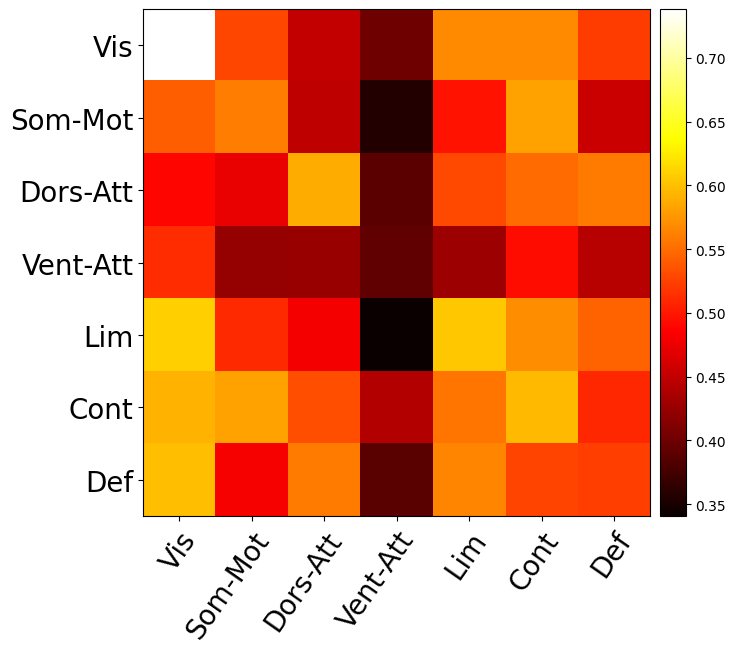

In [15]:
plt.figure(figsize = (7,7))
ax = plt.subplot()
im = plt.imshow(average_subnetwork_graph_over_all_subjects, cmap = 'hot')
ax.set_xticks(np.arange(num_cortical_networks), labels = net_labels_visualization[:-1] , fontsize = 20)
ax.set_yticks(np.arange(num_cortical_networks), labels = net_labels_visualization[:-1] , fontsize = 20)
g = plt.setp(ax.get_xticklabels(), rotation = 55, ha = "right",
         rotation_mode="anchor")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
   
plt.colorbar(im, cax=cax)

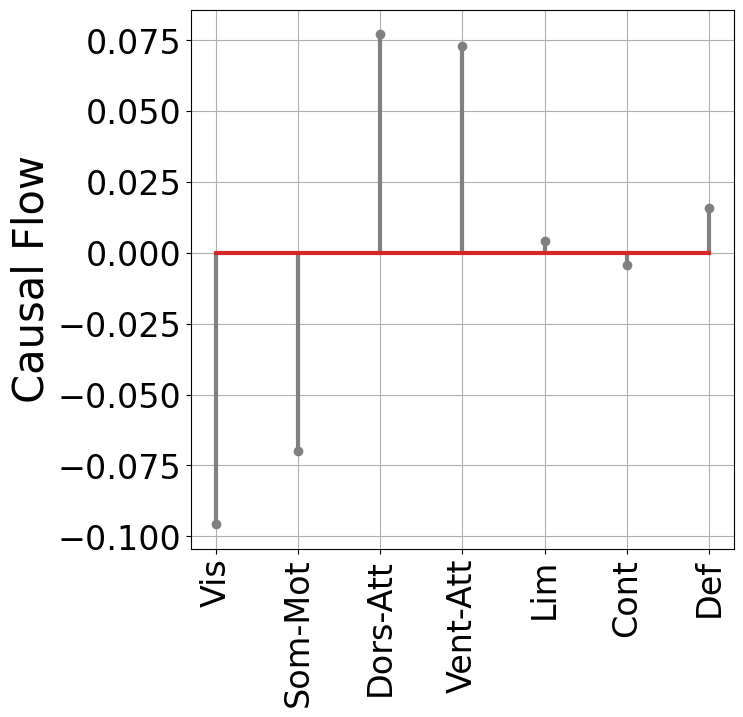

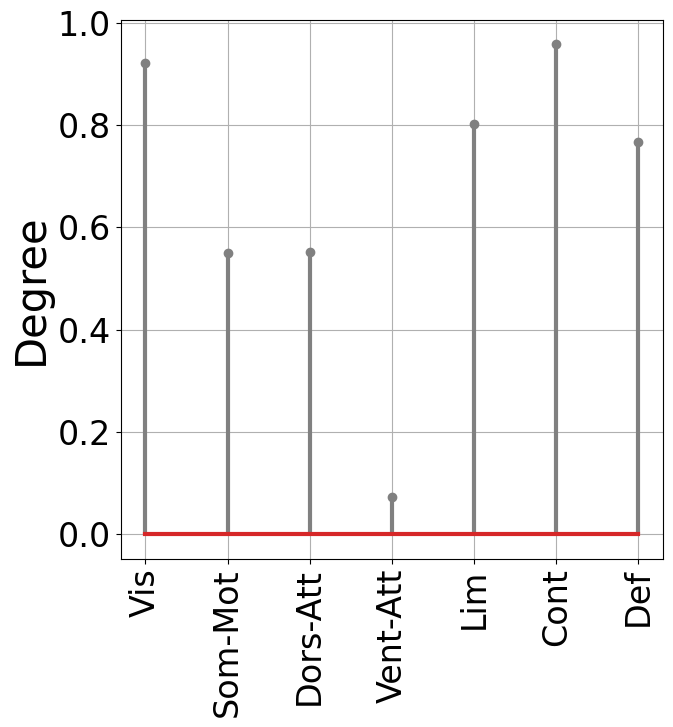

In [16]:
plt.figure(figsize = (7,7))
p = plt.stem(average_subnetwork_causal_flow, linefmt = 'gray')
plt.setp(p,'linewidth', 3)

plt.xticks(np.arange(0,num_cortical_networks), labels = net_labels_visualization[:-1], rotation = 90, fontsize = 24)
plt.ylabel('Causal Flow', fontsize = 30)
plt.yticks(fontsize = 24)
plt.grid()


plt.figure(figsize = (7,7))
p = plt.stem(average_subnetwork_nodal_degree, linefmt = 'gray')
plt.setp(p,'linewidth', 3)

plt.xticks(np.arange(0,num_cortical_networks), labels = net_labels_visualization[:-1], rotation = 90, fontsize = 24)
plt.ylabel('Degree', fontsize = 30)
plt.yticks(fontsize = 24)
plt.grid()


In [17]:
def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same


 
        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

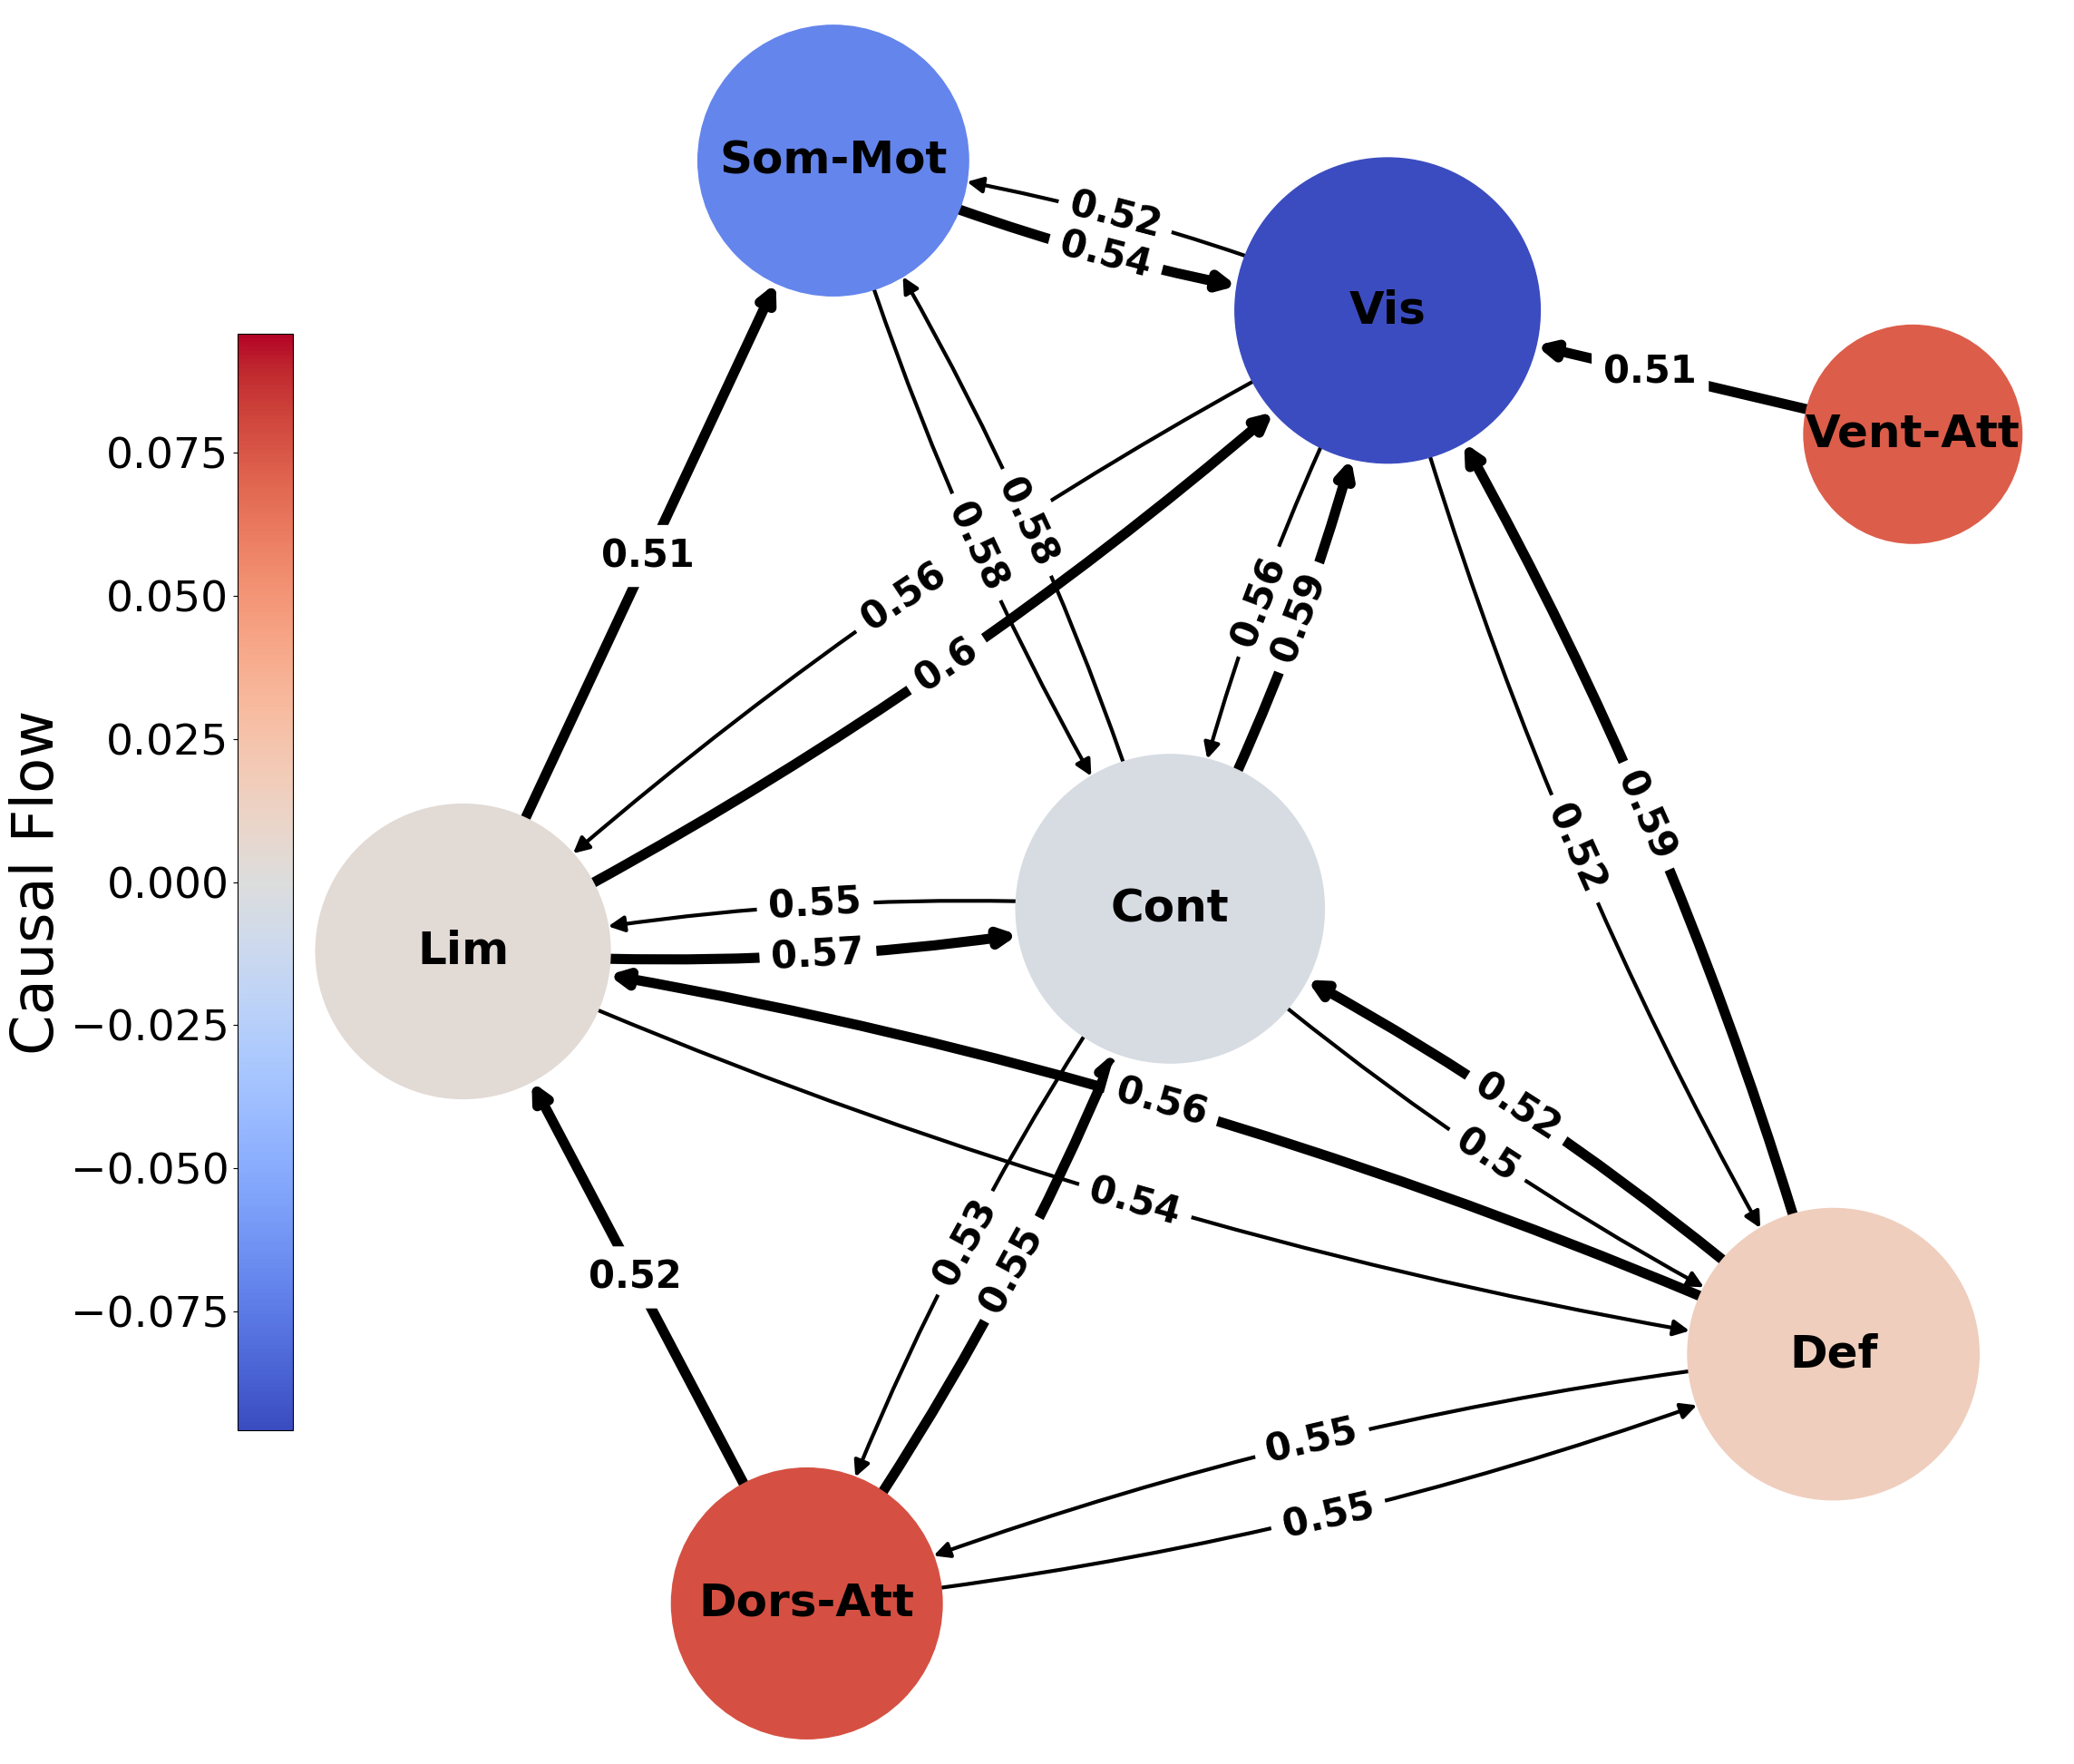

In [46]:
plt.figure(figsize=(26, 25))
ax = plt.subplot()
G = nx.DiGraph()

# Add nodes to the graph with actual labels from net_labels_visualization
node_labels = {i: label for i, label in enumerate(net_labels_visualization[:-1])}
G.add_nodes_from(node_labels.keys())

# Add edges with weights from the matrix
for i in range(len(average_subnetwork_graph_over_all_subjects_visualization)):
    for j in range(len(average_subnetwork_graph_over_all_subjects_visualization[i])):
        if average_subnetwork_graph_over_all_subjects_visualization[i][j] != 0:
            G.add_edge(i, j, weight=average_subnetwork_graph_over_all_subjects_visualization[i][j])

# pos = nx.spring_layout(G)
pos = nx.kamada_kawai_layout(G)
# pos = nx.shell_layout(G)
# pos = nx.spectral_layout(G)


##
# {0: 'Vis',
#  1: 'Som-Mot',
#  2: 'Dors-Att',
#  3: 'Vent-Att',
#  4: 'Lim',
#  5: 'Cont',
#  6: 'Def'}
pos[0] = pos[0] + [0.5,0.5]
pos[1] = pos[1] + [0.0, 0.3]
pos[2] = pos[2] + [0.1,0]
pos[3] = pos[3] + [0.9,0]
pos[4] = pos[4]+[-0.5,0]
pos[5] = pos[5] + [0.5, +0.2]
pos[6] = pos[6]+ [1.5,0]

# Extracting edge weights
curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
straight_edges = list(set(G.edges()) - set(curved_edges))

edge_weights  = nx.get_edge_attributes(G,'weight')

thick_width = 8
thin_width = 3

# straight edges
straight_edges_weight=[]
straight_edges_width = []
for i in range(0,len(straight_edges)):
    straight_edges_weight.append(edge_weights[straight_edges[i]])
    straight_edges_width.append(thick_width)

# curved edges
curved_edges_weight = []
curved_edges_width = []
for i in range(0,len(curved_edges)):
    curved_edges_weight.append(edge_weights[curved_edges[i]])

    opposite_edge = (curved_edges[i][1],curved_edges[i][0])

    if opposite_edge in curved_edges:
        if edge_weights[curved_edges[i]]> edge_weights[opposite_edge]:
            curved_edges_width.append(thick_width)
        else:
            curved_edges_width.append(thin_width)
    else:

            curved_edges_width.append(thick_width)



# Map normalized values to colors using the coolwarm colormap
colormap = 'coolwarm'
cmap = plt.get_cmap(colormap)
norm = colors.Normalize(vmin=-np.max(np.abs(average_subnetwork_causal_flow)), vmax=np.max(np.abs(average_subnetwork_causal_flow)))
node_colors = [cmap(norm(d)) for d in average_subnetwork_causal_flow]


min_node_size = 30000
max_node_size = 60000


node_sizes = min_node_size + (max_node_size - min_node_size) * ( average_subnetwork_nodal_degree- min(average_subnetwork_nodal_degree)) / (max(average_subnetwork_nodal_degree) - min(average_subnetwork_nodal_degree)) 
nx.draw_networkx_nodes(G, pos, ax = ax, node_color=node_colors, node_size=node_sizes )
nx.draw_networkx_labels(G, pos,ax = ax, labels=node_labels,  font_size=36, font_weight="bold")

plt.box(False)


arc_rad = 0.07
nx.draw_networkx_edges(G, pos,ax = ax, edgelist=curved_edges, width = curved_edges_width,  arrows = True, connectionstyle=f'arc3, rad = {arc_rad}', node_size=node_sizes, arrowsize= 26, edge_color = 'black')
nx.draw_networkx_edges(G, pos,ax = ax, edgelist=straight_edges,width = straight_edges_width , arrows = True, node_size = node_sizes, arrowsize= 26, edge_color = 'black')


curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}

my_draw_networkx_edge_labels(G, pos, edge_labels=curved_edge_labels,rad = arc_rad, font_size=30,font_color="k",font_family="sans-serif",font_weight="bold")
my_draw_networkx_edge_labels(G, pos, edge_labels=straight_edge_labels,rotate=False,  font_size=30,font_color="k",font_family="sans-serif",font_weight="bold")


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.01, location='left')
cbar.set_label('Causal Flow', fontsize = 46)
cbar.ax.tick_params(labelsize=34)


#### Nodal degree and Causal flow

#### Degree and causal flow of the subnetwork graphs of all the subjects

In [22]:
subnet_graph_degree_all = []
subnet_graph_causal_flow_all = []

for s in range(0, num_subjects_ready):
    subnet_graph = all_networks_num_edges_from_to_individual_sub[:,:,s]
    subnet_graph_degree = np.mean(subnet_graph, axis = 1) + np.mean(subnet_graph, axis = 0)
    subnet_graph_causal_flow = np.mean(subnet_graph, axis = 1) - np.mean(subnet_graph, axis = 0)
    subnet_graph_degree_all.append(subnet_graph_degree)
    subnet_graph_causal_flow_all.append(subnet_graph_causal_flow)

/tmp/ipykernel_490005/3640352343.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:,i], y[:,i], c = standard_colors[i,:], s = 5, label = net_labels_visualization[i],  marker = markers[i])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


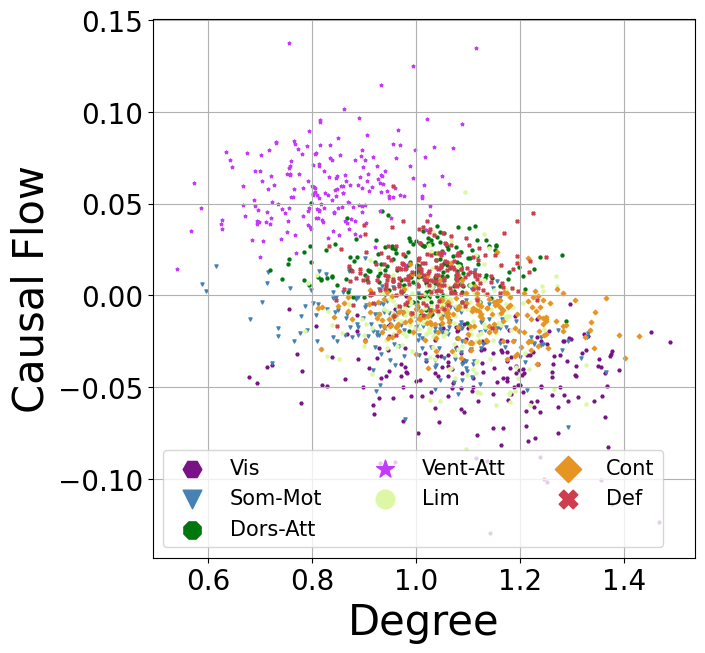

In [23]:
plt.figure(figsize = (7,7))

x = np.array(subnet_graph_degree_all)
y = np.array(subnet_graph_causal_flow_all)

markers = ['H', 'v','8', '*', 'o', 'D','X','>']

standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]])), axis = 0)

for i in range(0, num_cortical_networks):

    plt.scatter(x[:,i], y[:,i], c = standard_colors[i,:], s = 5, label = net_labels_visualization[i],  marker = markers[i])

plt.grid()
plt.xlabel('Degree', fontsize = 30)
plt.ylabel('Causal Flow', fontsize = 30)
plt.xticks(fontsize = 20 )
plt.yticks(fontsize = 20 )

plt.legend(fontsize = 15, ncol = 3, loc = 'lower left', markerscale = 6)

xmin, xmax, ymin, ymax = plt.axis()


/tmp/ipykernel_490005/2505794577.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x[:,i], y[:,i], c = standard_colors[i,:], s =10, marker = markers[i])


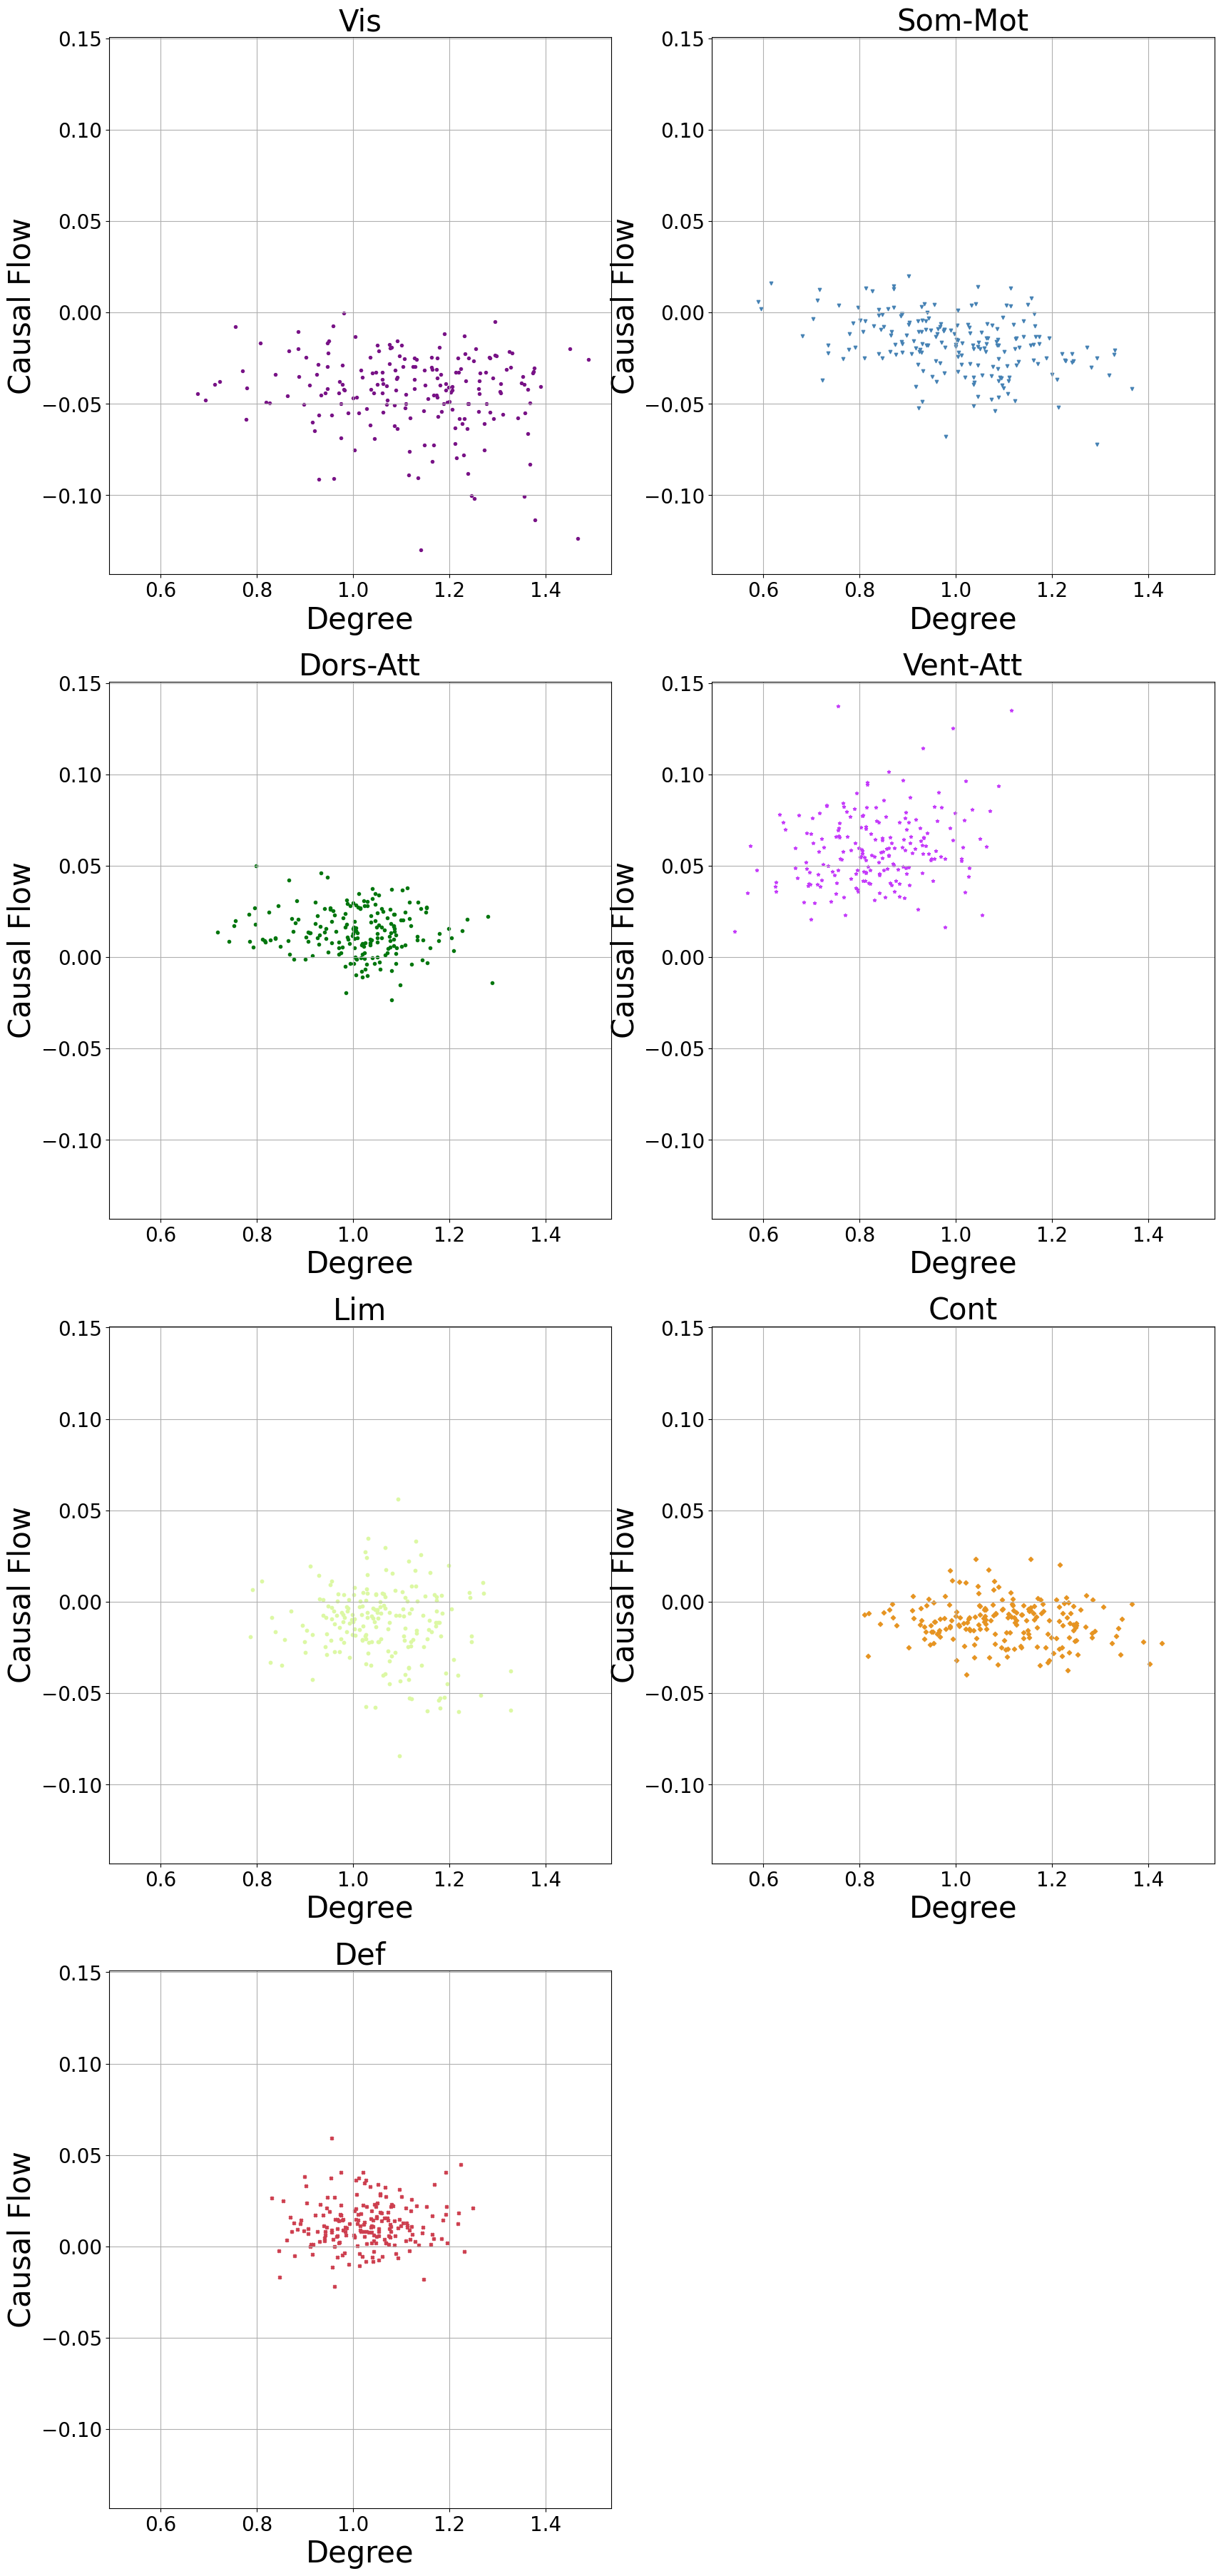

In [24]:
plt.figure(figsize = (20, 45))
x = np.array(subnet_graph_degree_all)
y = np.array(subnet_graph_causal_flow_all)
markers = ['H', 'v','8', '*', 'o', 'D','X','>']

standard_colors = np.concatenate((Yeo2011_7Networks_ColorLUT/255, np.array([[0, 0, 0]])), axis = 0)

for i in range(0, num_cortical_networks):

    plt.subplot(4,2,i+1)
    plt.scatter(x[:,i], y[:,i], c = standard_colors[i,:], s =10, marker = markers[i])

    plt.grid(visible = True)
    plt.xlabel('Degree', fontsize = 30)
    plt.ylabel('Causal Flow', fontsize = 30)
    plt.xticks(fontsize =20 )
    plt.yticks(fontsize = 20 )
    plt.title(net_labels_visualization[i], fontsize = 30)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin,ymax)

    # 